In [1]:
# -*- coding: utf-8 -*-
"""
@author: Crazy Trader
Description:
    This demo shows the simple EQ Short Trading with open price, high price and low price repeatedly captured during the trading hour

    The algorithm restricts only one position per product.
    
    For HSI derivatives:
    Open HSI Position with at most Qty 150 with arbitary 50 Qty of Option for Hedging at 10:00 on Trading Day
        - Volatility is high when VHSI > 20
        - Trend is based on Volume-Price Trend accumulated every trading day and reset after the trade
    Stoploss if index drops 1% of investment
    Close all Positions at 16:10
    
    For Forex Turkish Lira:
    Open and Close Positions solely based on event based strategy
    
    For Crypto Ripple:
    Open XRPUSD Position with at most Qty 420000 (only short position is allowed)
        - Volatility is high if VIX is 2 point higher than the open rate
        - Trend is based on Volume-Price Trend accumulated every trading day and reset after the trade
    Stoploss if index drops 1% of investment
    Close all Positions 5 days after the trade or VIX drops below the open rate
    
    NOTE:
        Option quantity is arbitary
        Actual amount has to be decided via Risk Management
"""

'\n@author: Crazy Trader\nDescription:\n    This demo shows the simple EQ Short Trading with open price, high price and low price repeatedly captured during the trading hour\n\n    The algorithm restricts only one position per product.\n    \n    For HSI derivatives:\n    Open HSI Position with at most Qty 150 with arbitary 50 Qty of Option for Hedging at 10:00 on Trading Day\n        - Volatility is high when VHSI > 20\n        - Trend is based on Volume-Price Trend accumulated every trading day and reset after the trade\n    Stoploss if index drops 1% of investment\n    Close all Positions at 16:10\n    \n    For Forex Turkish Lira:\n    Open and Close Positions solely based on event based strategy\n    \n    For Crypto Ripple:\n    Open XRPUSD Position with at most Qty 420000 (only short position is allowed)\n        - Volatility is high if VIX is 2 point higher than the open rate\n        - Trend is based on Volume-Price Trend accumulated every trading day and reset after the trade

In [2]:
# %% Library & Initialize Dataset and Backtesting Platform
from library.functions import *

dataset = {}
#dataset['0005.HK'] = 'EQ'  # Close, Volume
#dataset['0700.HK'] = 'EQ'  # Close, Volume
dataset['HSI'] = 'EQ'  # Close, Volume
dataset['PUT'] = 'Custom'  # requires functions
dataset['CALL'] = 'Custom'  # requires functions
dataset['VHSI'] = 'Vol'  # Close
dataset['VIX'] = 'Vol'  # Close
dataset['USDHKD'] = 'FX'  # Bid, Ask
dataset['XAUHKD'] = 'FX'  # Bid, Ask
dataset['HKDTRY'] = 'FX'  # Bid, Ask
dataset['USDTRY'] = 'FX'  # Bid, Ask
dataset['XRPUSD'] = 'FX'  # Bid, Ask
# load dataset and setup initial cash + default handling fee
platform = backtest(10000000, 100, dataset)

Dataset HSI is loaded
Dataset VHSI is loaded
Dataset VIX is loaded
Dataset USDHKD is loaded
Dataset XAUHKD is loaded
Dataset HKDTRY is loaded
Dataset USDTRY is loaded
Dataset XRPUSD is loaded
Dataset Range: from 2018-08-07 09:31:00 to 2018-12-07 16:01:00


In [3]:
# %% Functions
def getvpt(prev_vpt, volume, prev_close, this_close):
    this_vpt = prev_vpt + volume * (this_close - prev_close) / prev_close
    return this_vpt

In [4]:
# %% Backtest Params
start = platform.validstart  # initialize start date
end = platform.validend  # initialize start date
start = datetime.datetime(2018, 9, 1, 0, 0, 0)  # initialize start date
end = datetime.datetime(2018, 12, 1, 0, 0, 0)  # initialize start date
mask = (platform.quote['USDHKD'].index > start) & (platform.quote['USDHKD'].index <= end)
backtestperiod = platform.quote['USDHKD'].loc[mask]
platform.initportfolio(10000000, 100)  # reset initial cash + default handling fee

In [5]:
# %% Backtesting
prev = None  # for accessing last minute quotation
# start looping every 1 minute
print('Start Backtesting...')
for time, reference in backtestperiod.iterrows():
    # Examples:
    if not prev:  # skip first loop to record the time
        # initialize params
        prev = time
        prev_vpt = 0                                            # last volume-price trend
        this_vpt = 0                                            # this volume-price trend
        this_vpt_volume = 0                                     # this volume
        prev_vpt_price = platform.quote['HSI'].loc[time].Close  # last VPT price
        this_vpt_price = platform.quote['HSI'].loc[time].Close  # this VPT price
        
        hsi_rate    = None
        
        # XRPUSD 
        prev_vix = platform.quote['VIX'].loc[time].Close        # last VPT price
        this_vix = platform.quote['VIX'].loc[time].Close        # last VPT price
        vix_open = platform.quote['VIX'].loc[time].Close        # last VPT price
        xrp_rate    = None
        xrp_vix     = None
        xrp_date    = None
        xrp_delta   = None
        xrp_loss    = 0
        continue

    # Check if EQ market is opened
    if platform.is_eqmktopen(time):

        # Volume-Price Trend: accumulating volume until VPT calcuation
        this_vpt_volume = this_vpt_volume + platform.quote['HSI'].loc[time].Volume

        # Trade conditions
        if (
                time.time() == datetime.time(10, 0, 0)  # One trade per day at 10:00
        ):
            # Calculation VPT once per day
            this_vpt_price = platform.quote['HSI'].loc[time].Close  # Save the VPT price for VPT calculation
            this_vpt = getvpt(prev_vpt, this_vpt_volume, prev_vpt_price, this_vpt_price)  # Calculate VPT

            if (
                    not platform.has_pos('HSI')  # no position exists
                    and this_vpt < prev_vpt  # Trned is downward
                    and platform.quote['VHSI'].loc[time].Close < 20  # Volatility is low (e.g. 20 is arbitary value)
            ):
                platform.trade(time, 'HSI', 'SHORT', 150)  # Short 350 Qty of HSI Future                
                option_maturity = time.month  # option maturity
                option_strike = (int(platform.quote['HSI'].loc[
                                         time].Close / 200) - 2) * 200  # option step: 200 - around 400 points from the underlying price
                platform.trade(time, 'CALL', 'SHORT', 50, option_strike, option_maturity)

            if (
                    not platform.has_pos('HSI')  # no position exists
                    and this_vpt < prev_vpt  # Trned is downward
                    and platform.quote['VHSI'].loc[time].Close > 20  # Volatility is high (e.g. 20 is arbitary value)
            ):
                platform.trade(time, 'HSI', 'SHORT', 150)  # Short 350 Qty of HSI Future
                option_maturity = time.month  # option maturity
                option_strike = (int(platform.quote['HSI'].loc[
                                         time].Close / 200) - 2) * 200  # option step: 200 - around 400 points from the underlying price
                platform.trade(time, 'PUT', 'LONG', 50, option_strike, option_maturity)
            if (
                    not platform.has_pos('HSI')  # no position exists
                    and this_vpt > prev_vpt  # Trned is upward
                    and platform.quote['VHSI'].loc[time].Close < 20  # Volatility is low (e.g. 20 is arbitary value)
            ):
                platform.trade(time, 'HSI', 'LONG', 150)  # long 350 Qty of HSI Future
                option_maturity = time.month  # option maturity
                option_strike = (int(platform.quote['HSI'].loc[
                                         time].Close / 200) - 2) * 200  # option step: 200 - around 400 points from the underlying price
                platform.trade(time, 'PUT', 'SHORT', 50, option_strike, option_maturity)

            if (
                    not platform.has_pos('HSI')  # no position exists
                    and this_vpt > prev_vpt  # Trned is upward
                    and platform.quote['VHSI'].loc[time].Close > 20  # Volatility is high(e.g. 20 is arbitary value)
            ):
                platform.trade(time, 'HSI', 'LONG', 150)  # long 350 Qty of HSI Future
                option_maturity = time.month  # option maturity
                option_strike = (int(platform.quote['HSI'].loc[
                                         time].Close / 200) - 2) * 200  # option step: 200 - around 400 points from the underlying price
                platform.trade(time, 'CALL', 'LONG', 50, option_strike, option_maturity)

            # VPT preparation
            this_vpt_volume = 0  # reset VPT volume for next day accumulation
            prev_vpt_price = this_vpt_price  # Save today's vpt price for next day
            prev_vpt = this_vpt  # Save today's vpt for next day
            
            #stop-loss
            hsi_rate = platform.quote['HSI'].loc[time].Close
            
        # Close conditions
        if (
                time.time() == datetime.time(16, 10, 0)  # Close everything at 16:10
        ):
#            if platform.has_pos('HSI'):  # Check if position exists
            platform.trade(time, 'HSI', 'CLOSE')  # Close HSI Future
            platform.trade(time, 'CALL', 'CLOSE')  # Close HSI Call Option
            platform.trade(time, 'PUT', 'CLOSE')                                                # Close HSI Put Option
        
        # Stoploss
        if (    
                platform.has_pos('HSI')                                                           # Check if position exists
            ):
            hsi_loss = float(platform.quote['HSI'].loc[time].Close - hsi_rate) /  hsi_rate        # calculate loss rate for stoploss
            if (
                  hsi_loss > 0.01                                                                 # Stoploss: 1%
            ):
                platform.trade(time, 'HSI', 'CLOSE')                                              # Close HSI Future
                hsi_rate = None                                                                   # Clear trade rate
                
    # EQ is not in trading hours
    else:
        pass

    # Check if FX and Crypto markets are opened
    if platform.is_fxmktopen(time):
        # Trade HKDTRY - Short Position only based on Event Driven Strategy
        if ( 
                time.timestamp() == datetime.datetime(2018,  9, 1, 17, 0, 0).timestamp()            # Trade on 1st of Sep
                ):
            platform.trade(time, 'HKDTRY', 'SHORT', 3000000)                                        # Short HKDTRY
        if ( 
                time.timestamp() == datetime.datetime(2018, 10, 15, 17, 0, 0).timestamp()           # Trade on 15th of Oct
                ):
            platform.trade(time, 'HKDTRY', 'CLOSE')                                                 # Close HKDTRY
            platform.trade(time, 'HKDTRY', 'SHORT', 4000000)                                        # Short HKDTRY
        if ( 
                time.timestamp() == datetime.datetime(2018, 11, 30, 17, 0, 0).timestamp()           # Close on 30th of Nov
                ):
            platform.trade(time, 'HKDTRY', 'CLOSE')                                                 # Close HKDTRY
            
        # Trade XRPUSD - Short Position only based on VIX
        if time.time() == datetime.time(15, 16, 0):                                                 # VIX market open
            vix_open = platform.quote['VIX'].loc[time].Close                                        # Capture Open Price
            if not platform.has_pos('XRPUSD'):                                                      # no position
                xrp_date = None                                                                     # Clear open date for new trade
        this_vix = platform.quote['VIX'].loc[time].Close                                            # Capture Current Price
        
        if ( 
                not platform.has_pos('XRPUSD')                                                      # No Position of Ripple
            and not xrp_date                                                                        # No Trade today
            and this_vix - vix_open > 2                                                             # VIX rises 2 points above open price
                ):           
            platform.trade(time, 'XRPUSD', 'SHORT', 420000)                                         # Open Short Position
            xrp_rate = platform.quote['XRPUSD'].loc[time].Ask                                       # Note down trade rate
            xrp_vix = platform.quote['VIX'].loc[time].Close                                         # Note down VIX at trade
            xrp_date = time                                                                         # Note down trade date

        # Close conditions
        if xrp_date:                                                                                # Trade is done
            xrp_delta = xrp_date - time                                                             # calculate date after open postion

        if (    
                platform.has_pos('XRPUSD')                                                          # Check if position exists
            and xrp_date                                                                            # trade date exists
            ):
            xrp_loss = float(platform.quote['XRPUSD'].loc[time].Ask - xrp_rate) /  xrp_rate         # calculate loss rate for stoploss
            if (
                    xrp_delta.days >= 5                                                             # 5 days after the trade
                or  vix_open - this_vix > 0                                                         # VIX drop below VIX at trade
                or  xrp_loss > 0.01                                                                 # Stoploss: 1%
            ):
                platform.trade(time, 'XRPUSD', 'CLOSE')                                             # Close XRP Future
                xrp_rate = None                                                                     # Clear trade rate
                xrp_vix  = None                                                                     # Clear VIX at trade

    prev = time  # Save this time for next loop

    # Update position info once a day: Unrealized, realized P&L
    if time.timestamp() % 86400 == 0:
        platform.updatepos(time)

Start Backtesting...


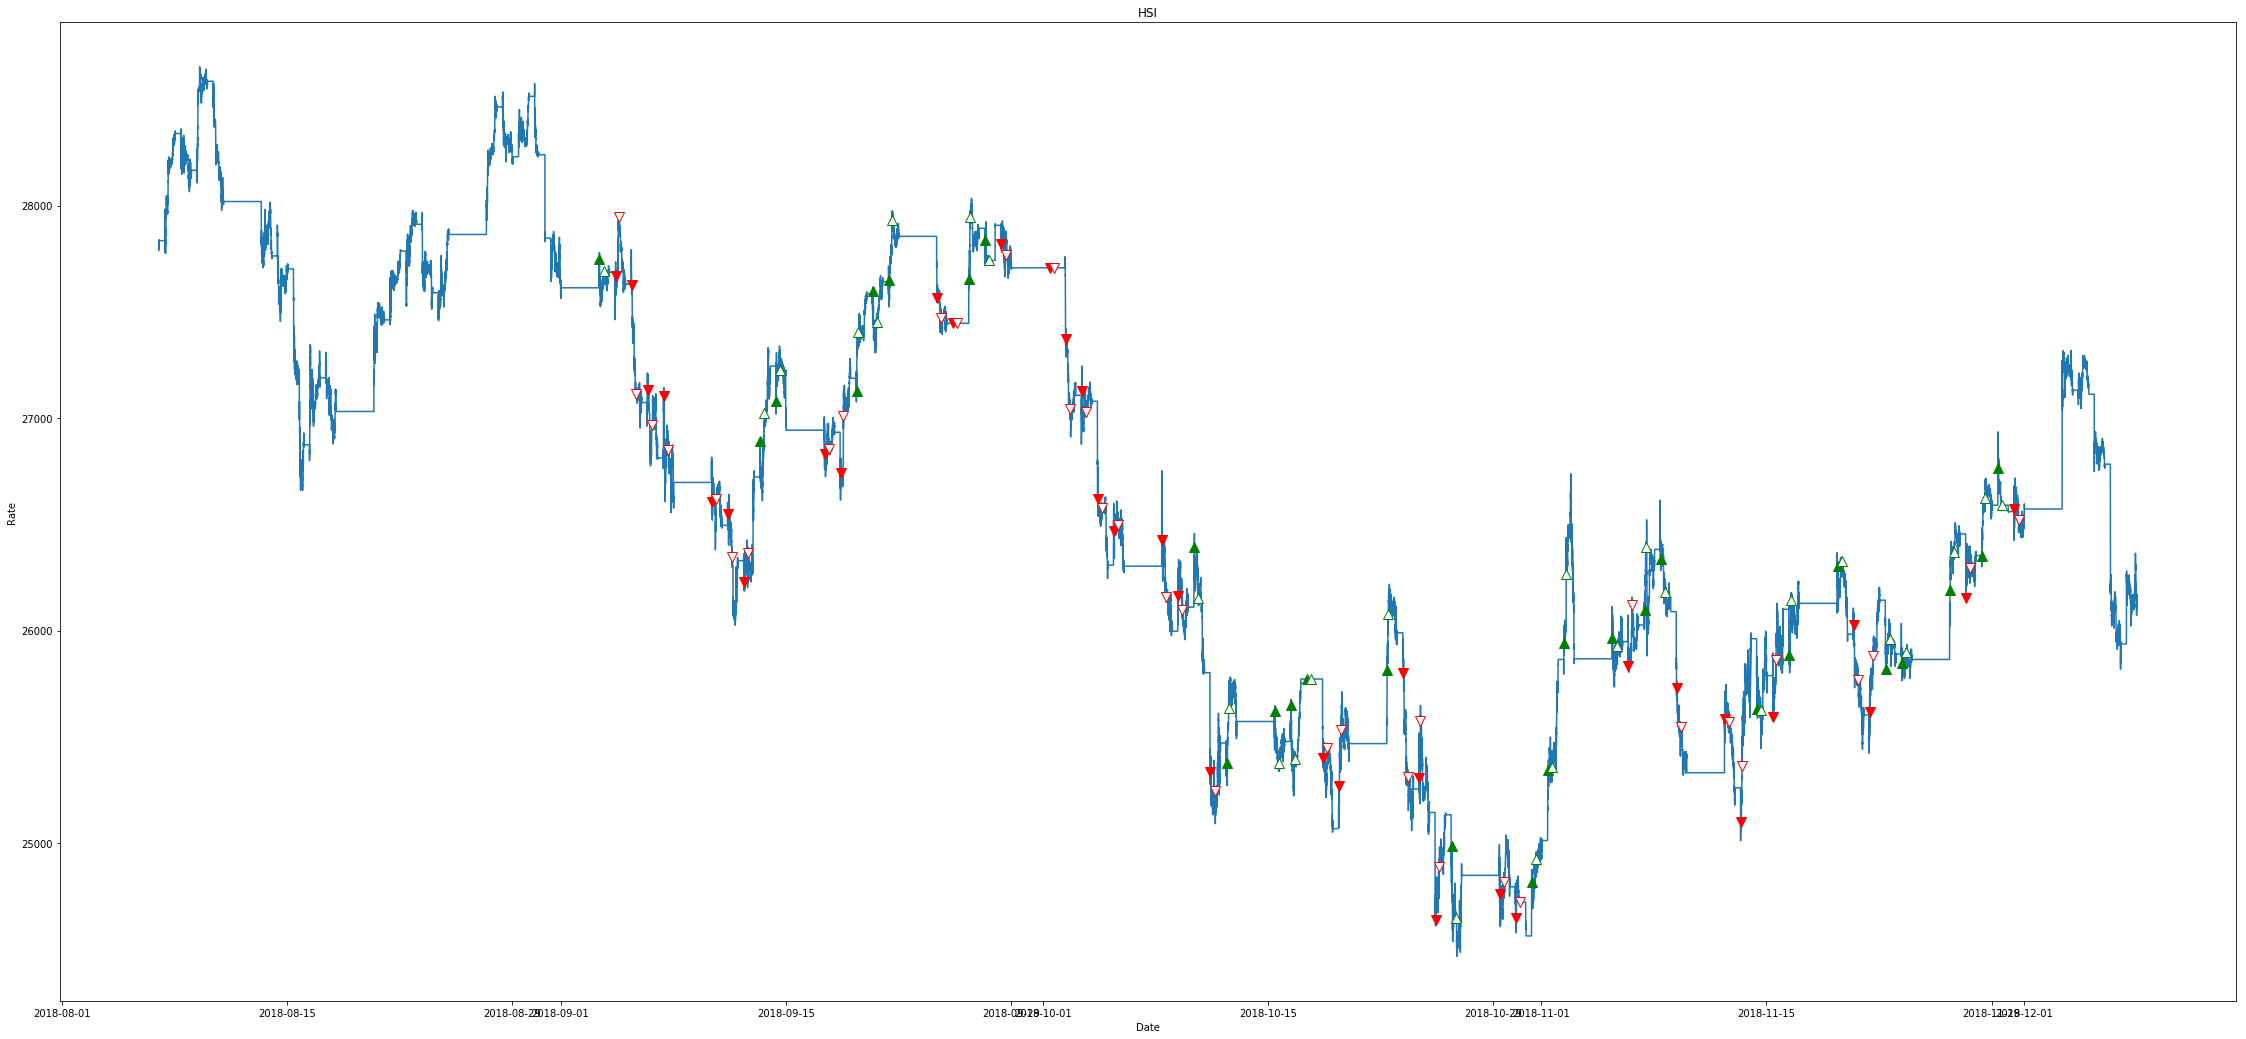

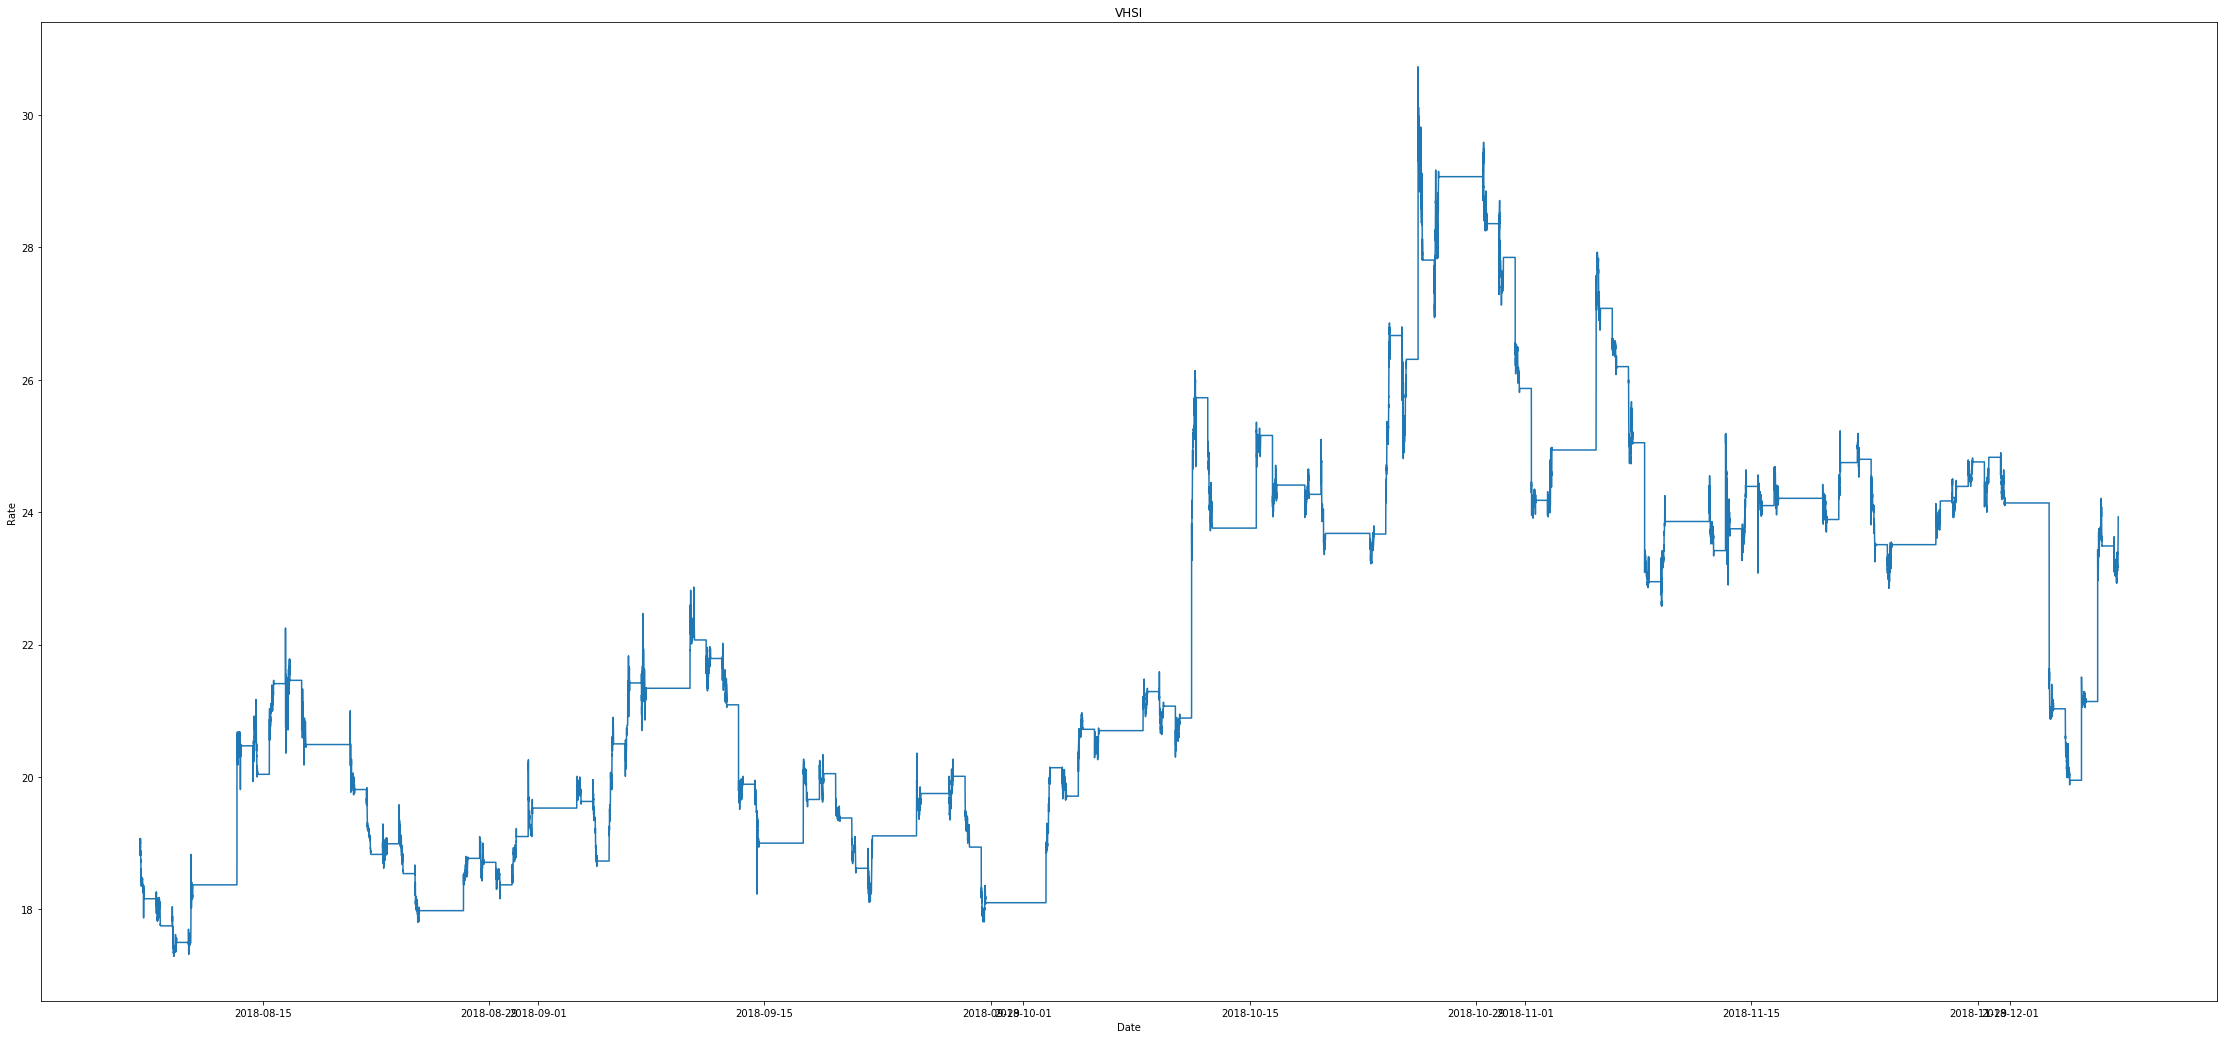

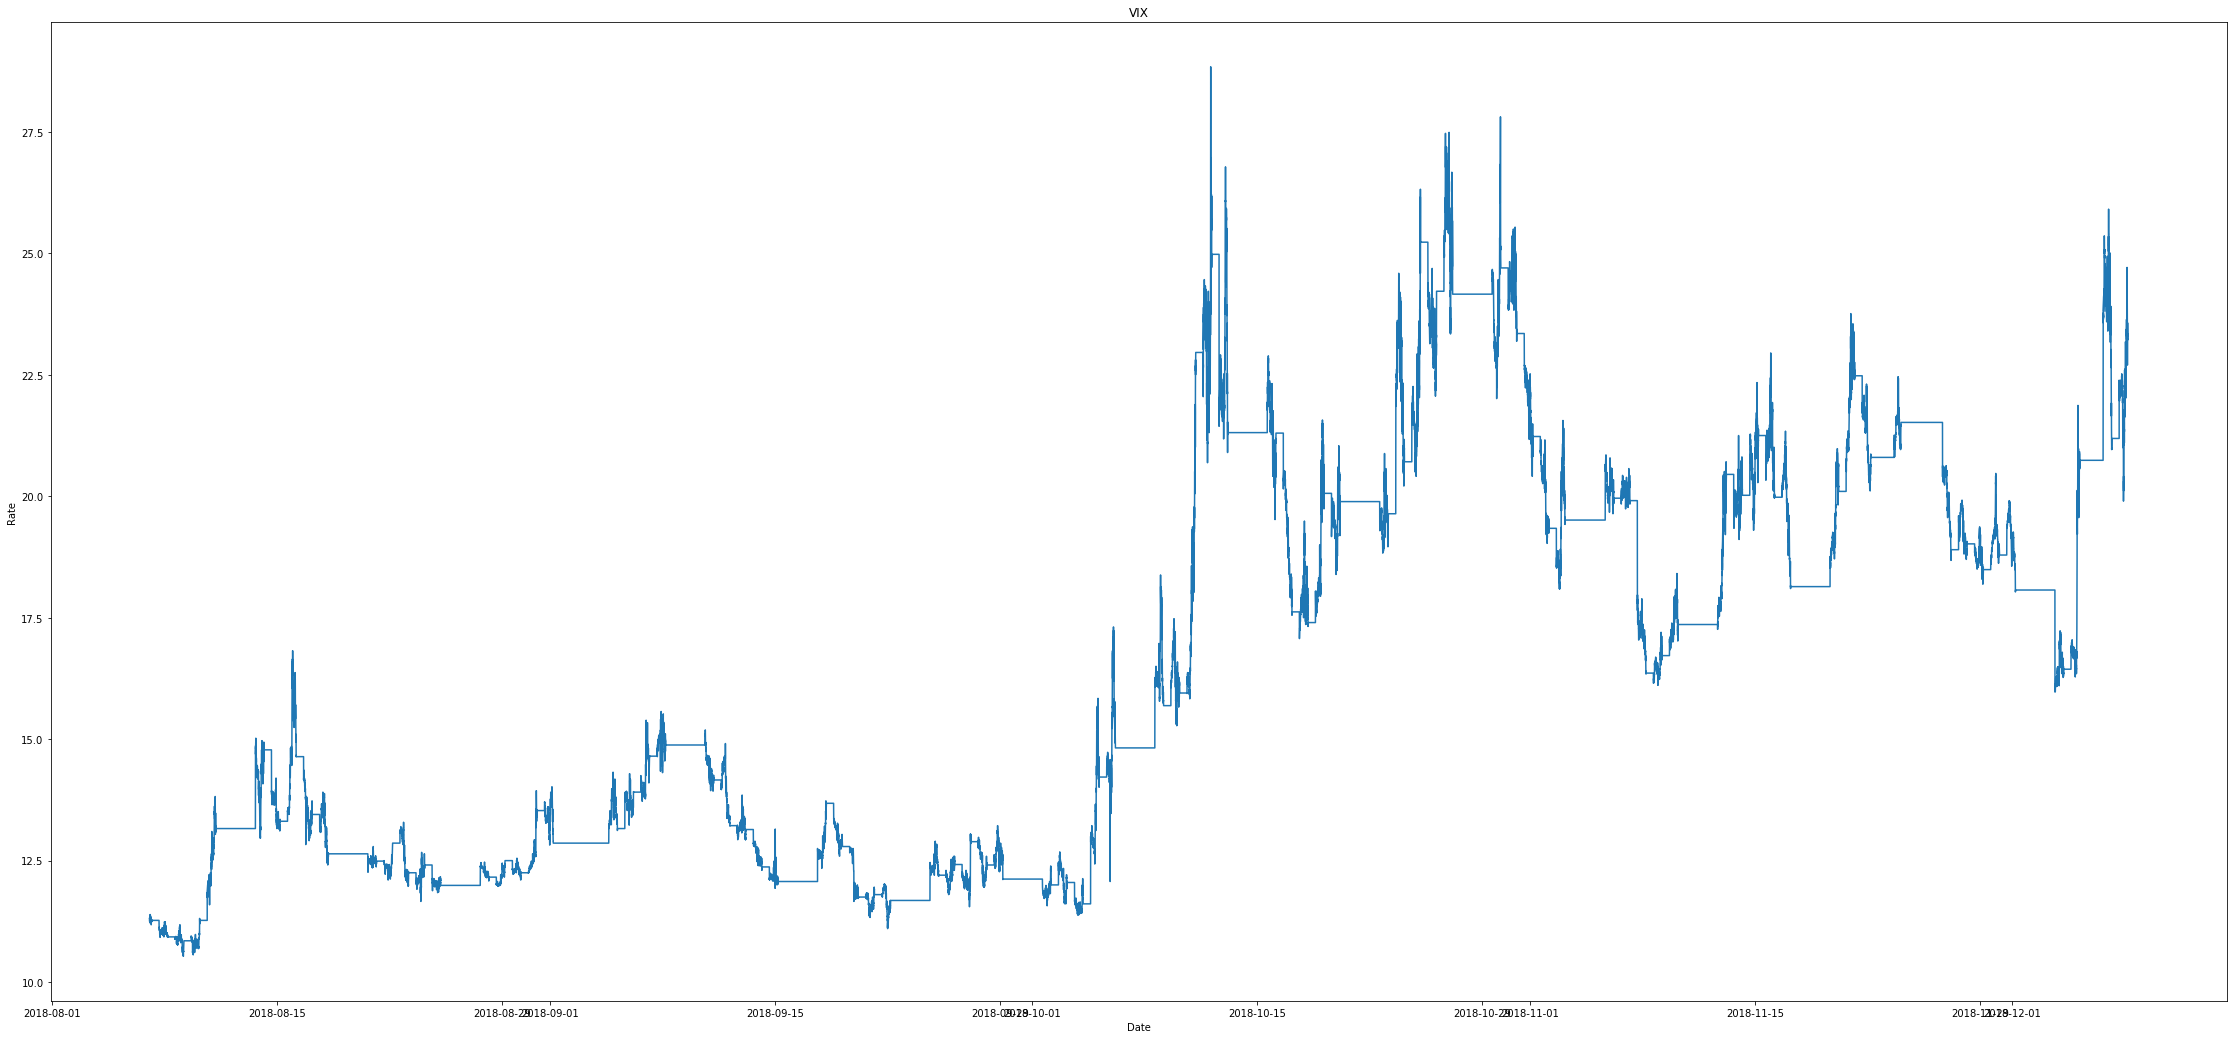

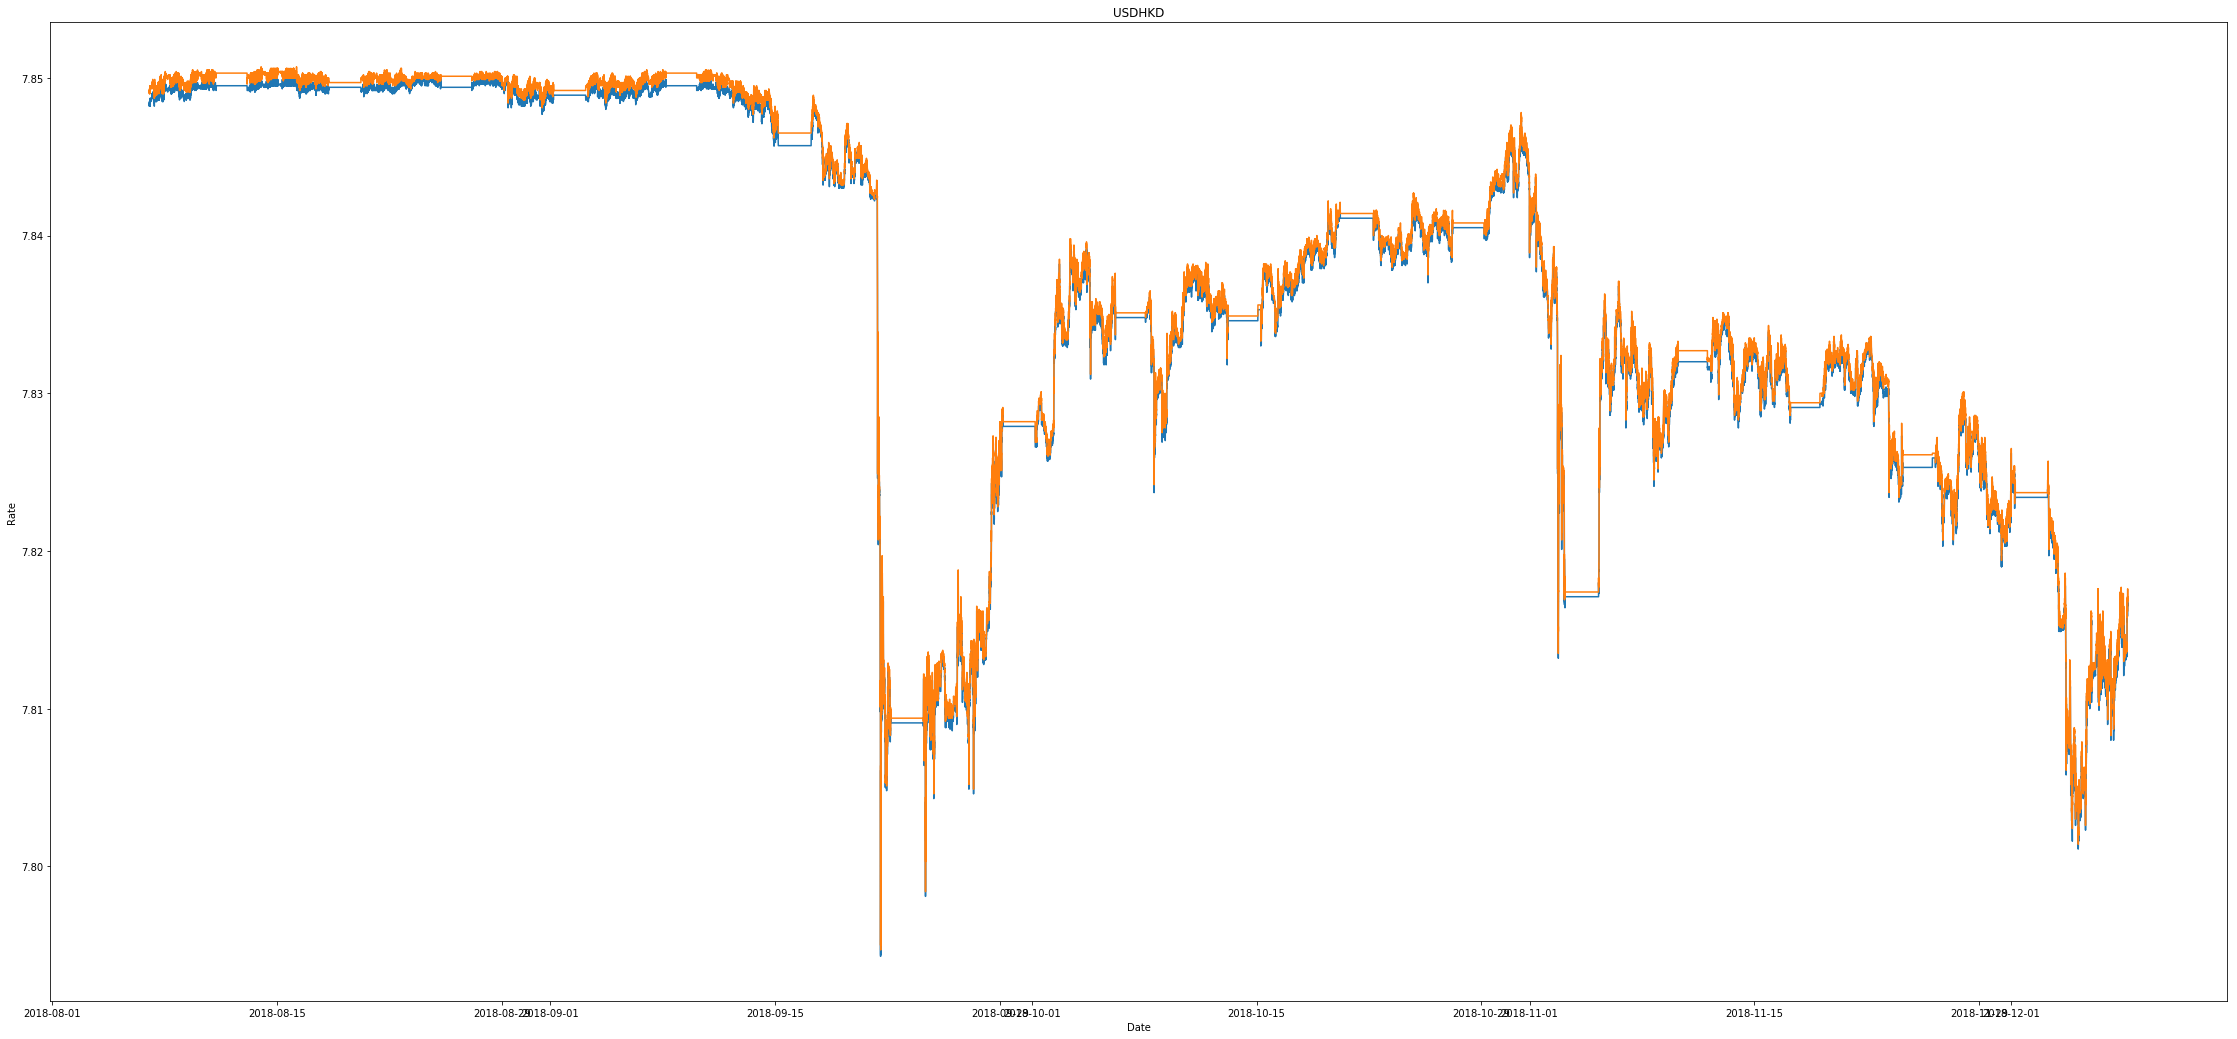

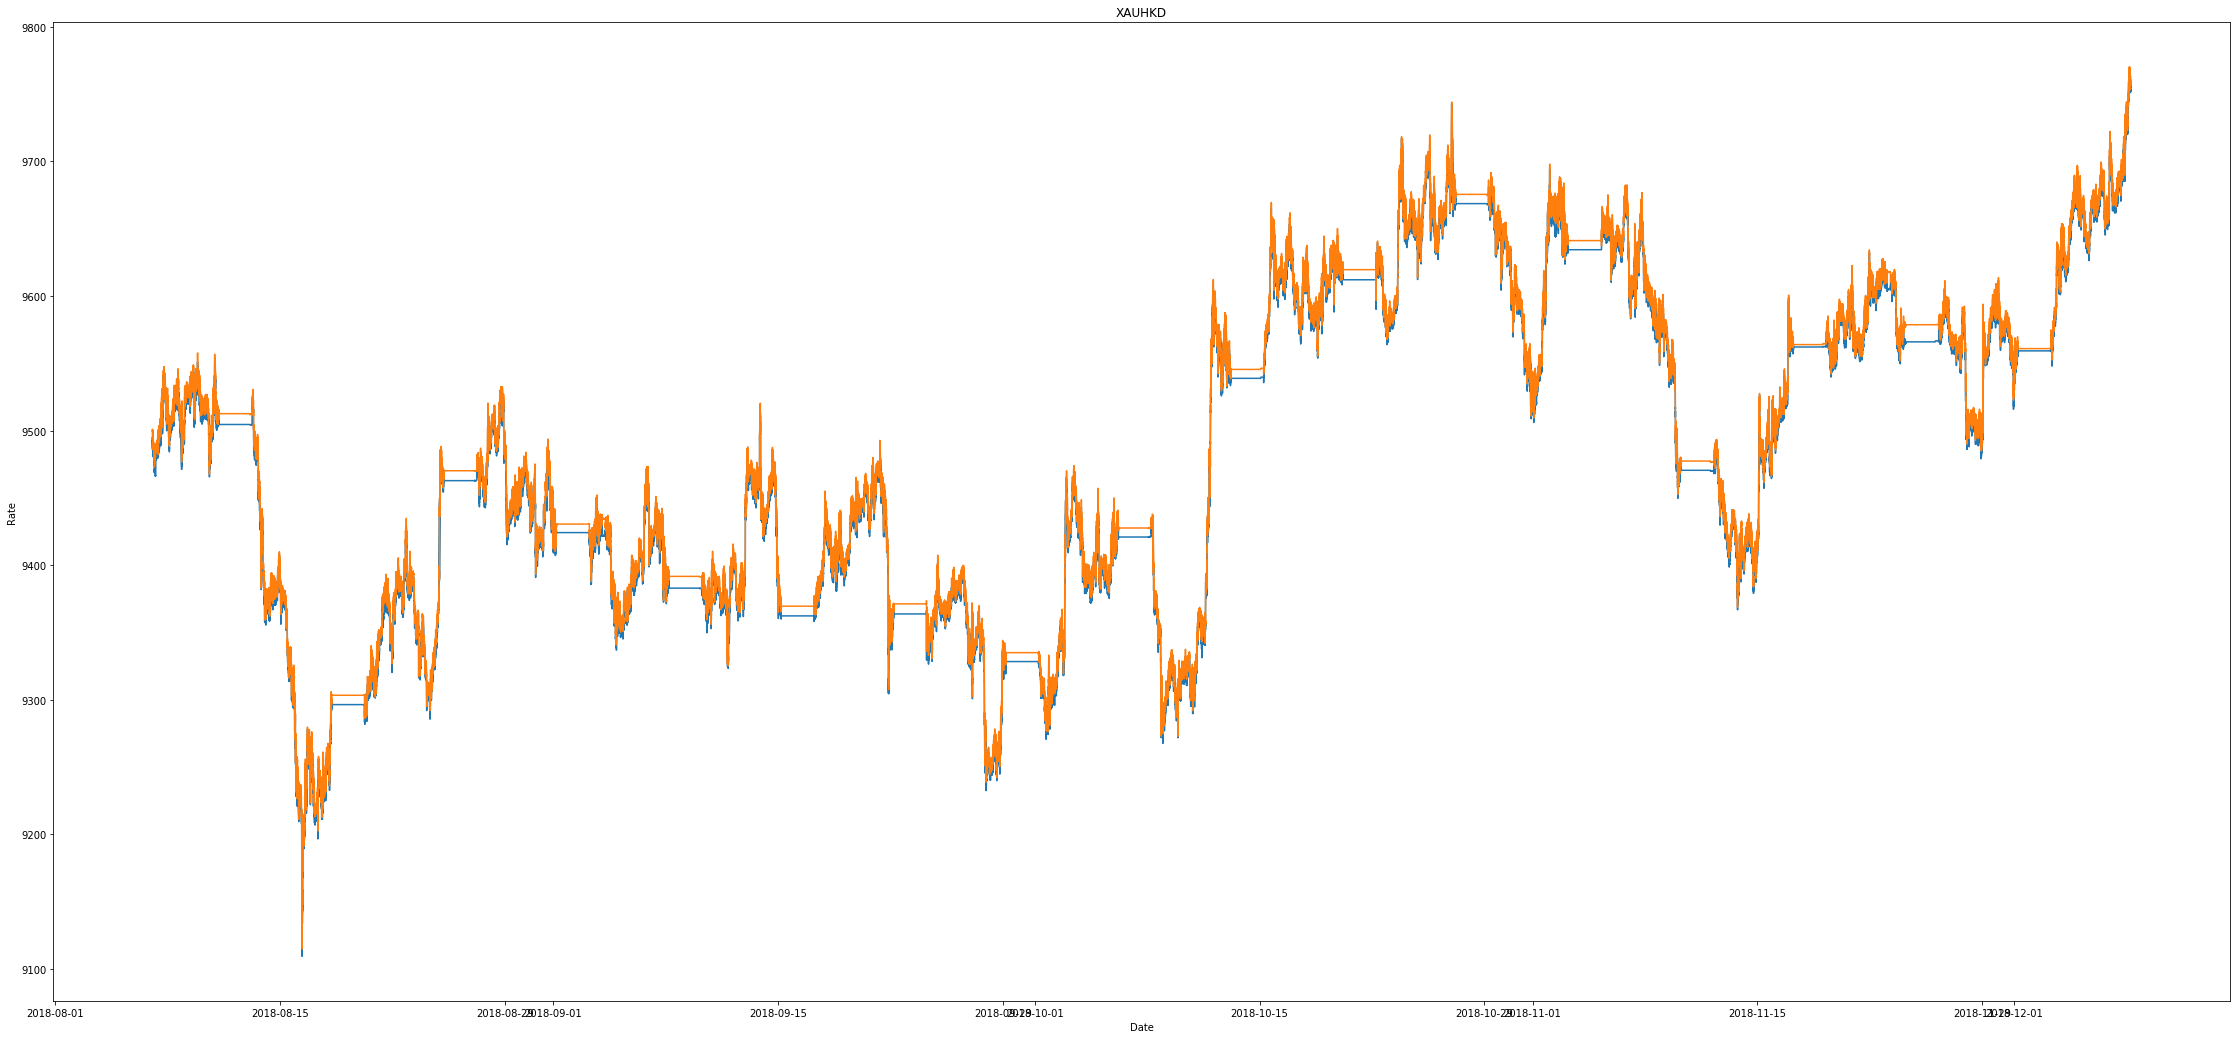

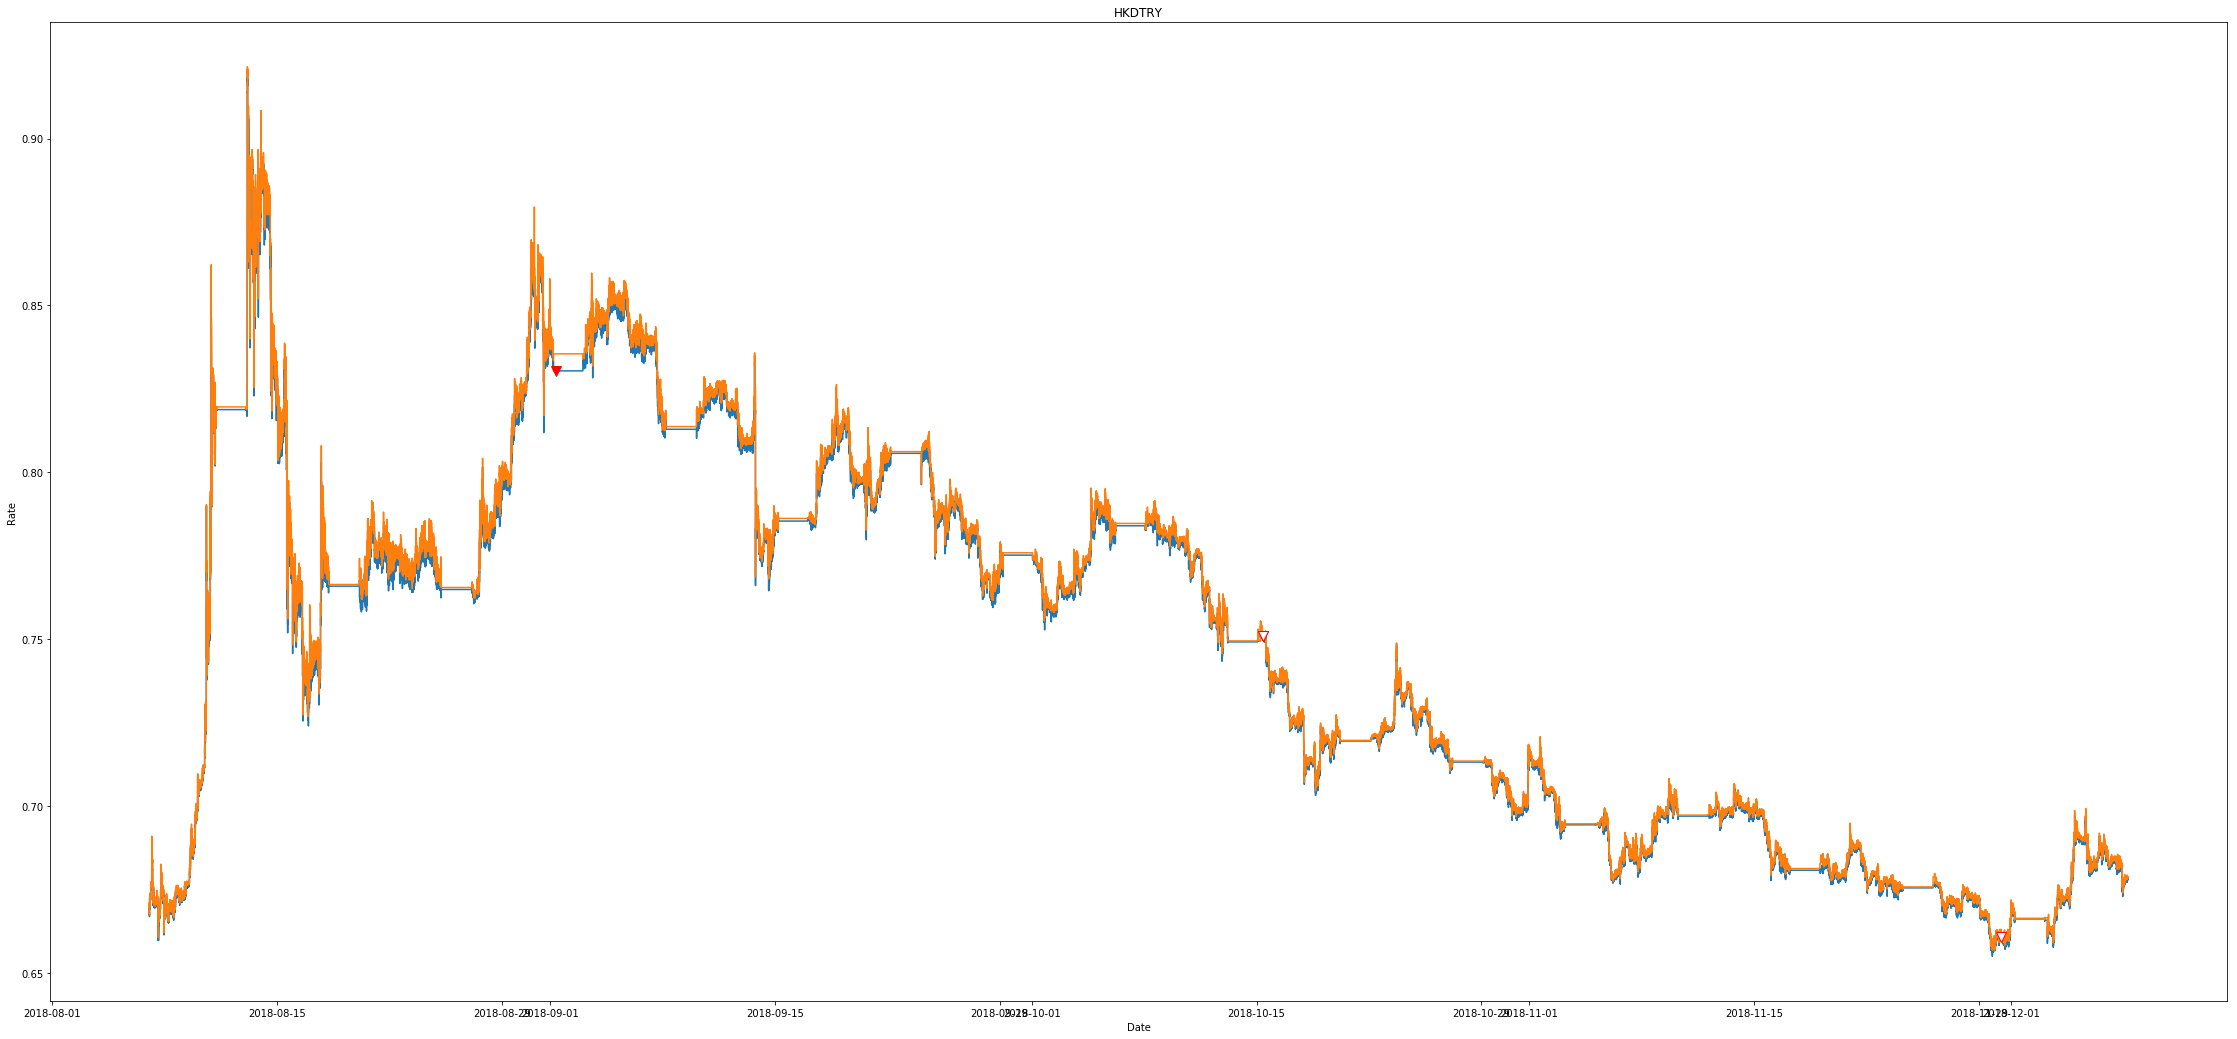

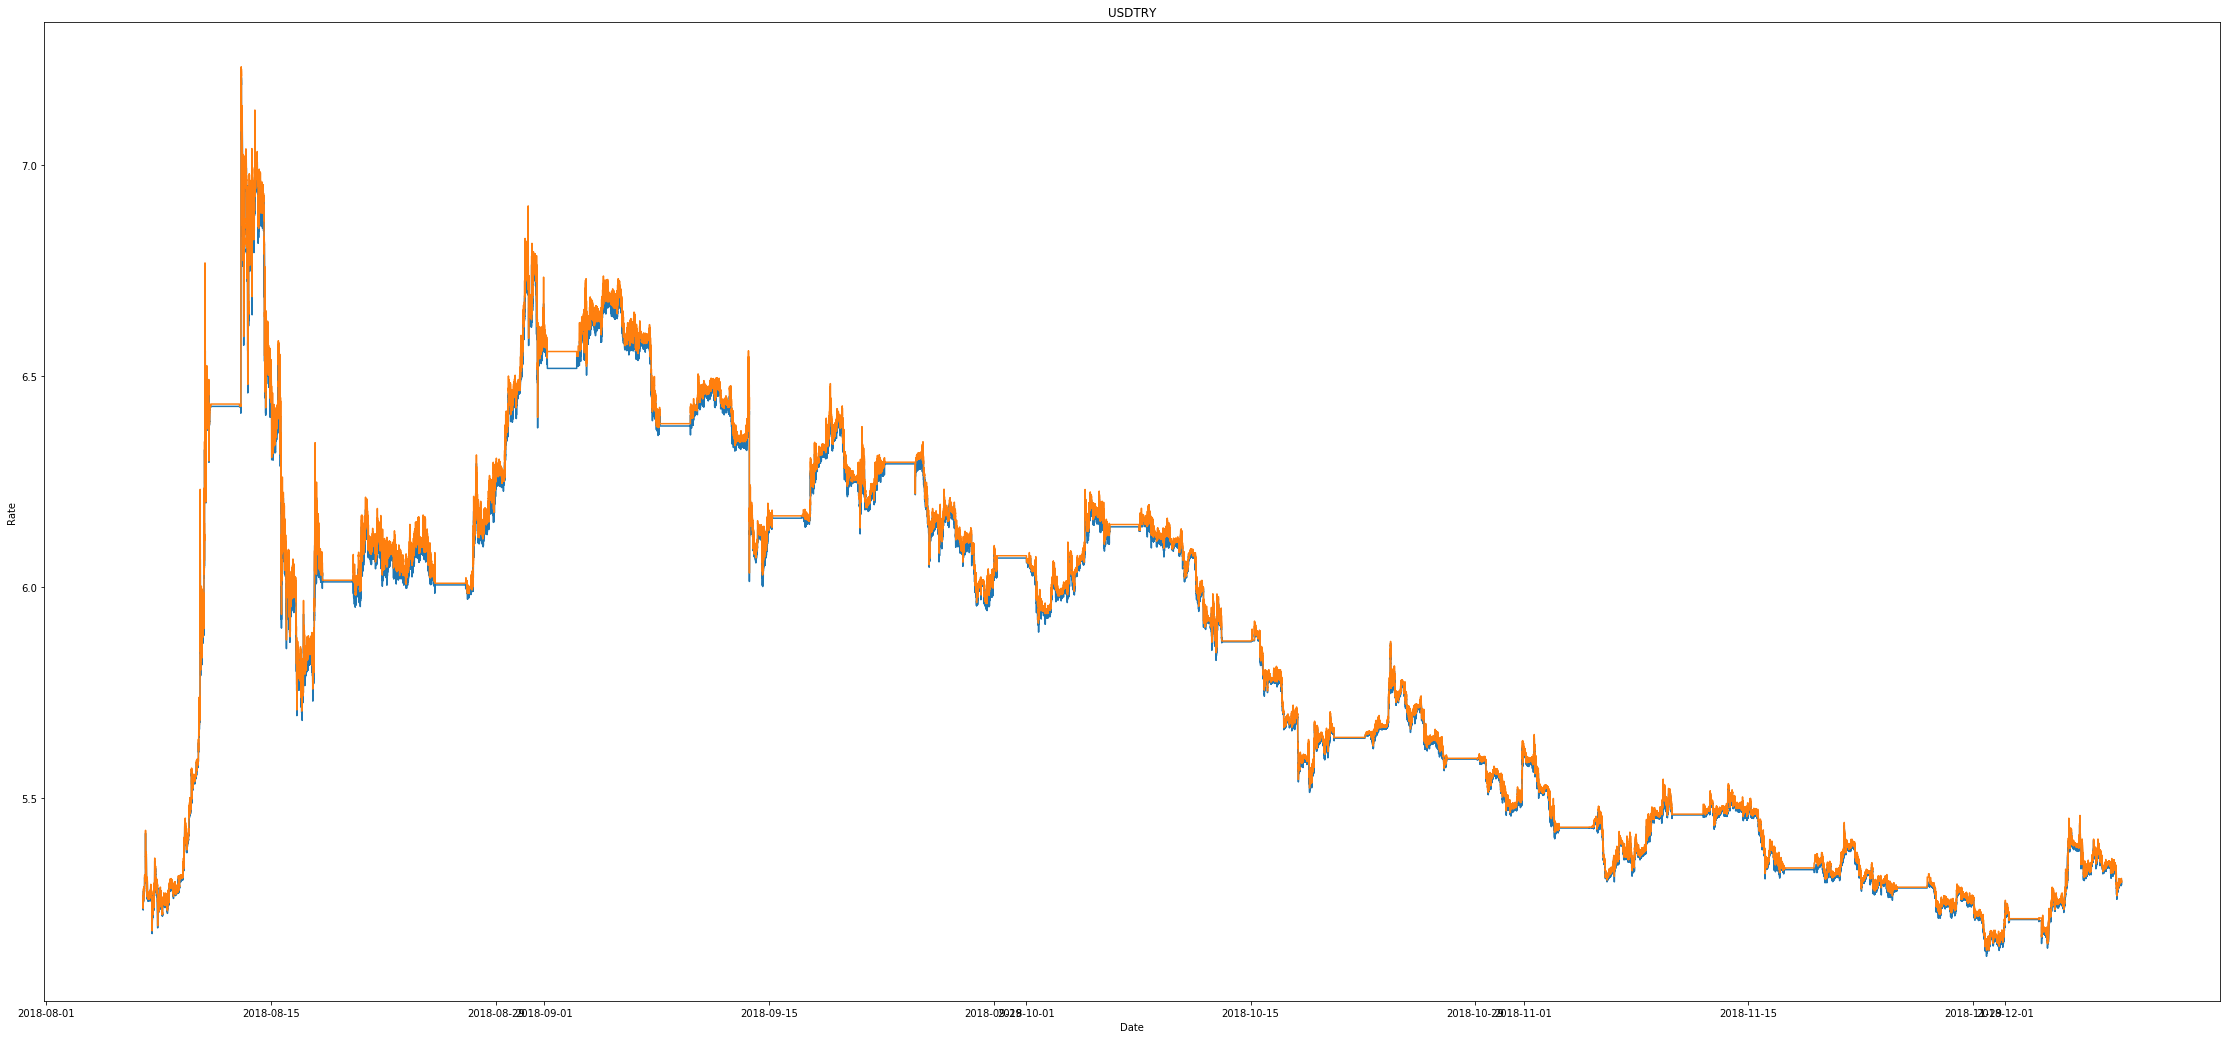

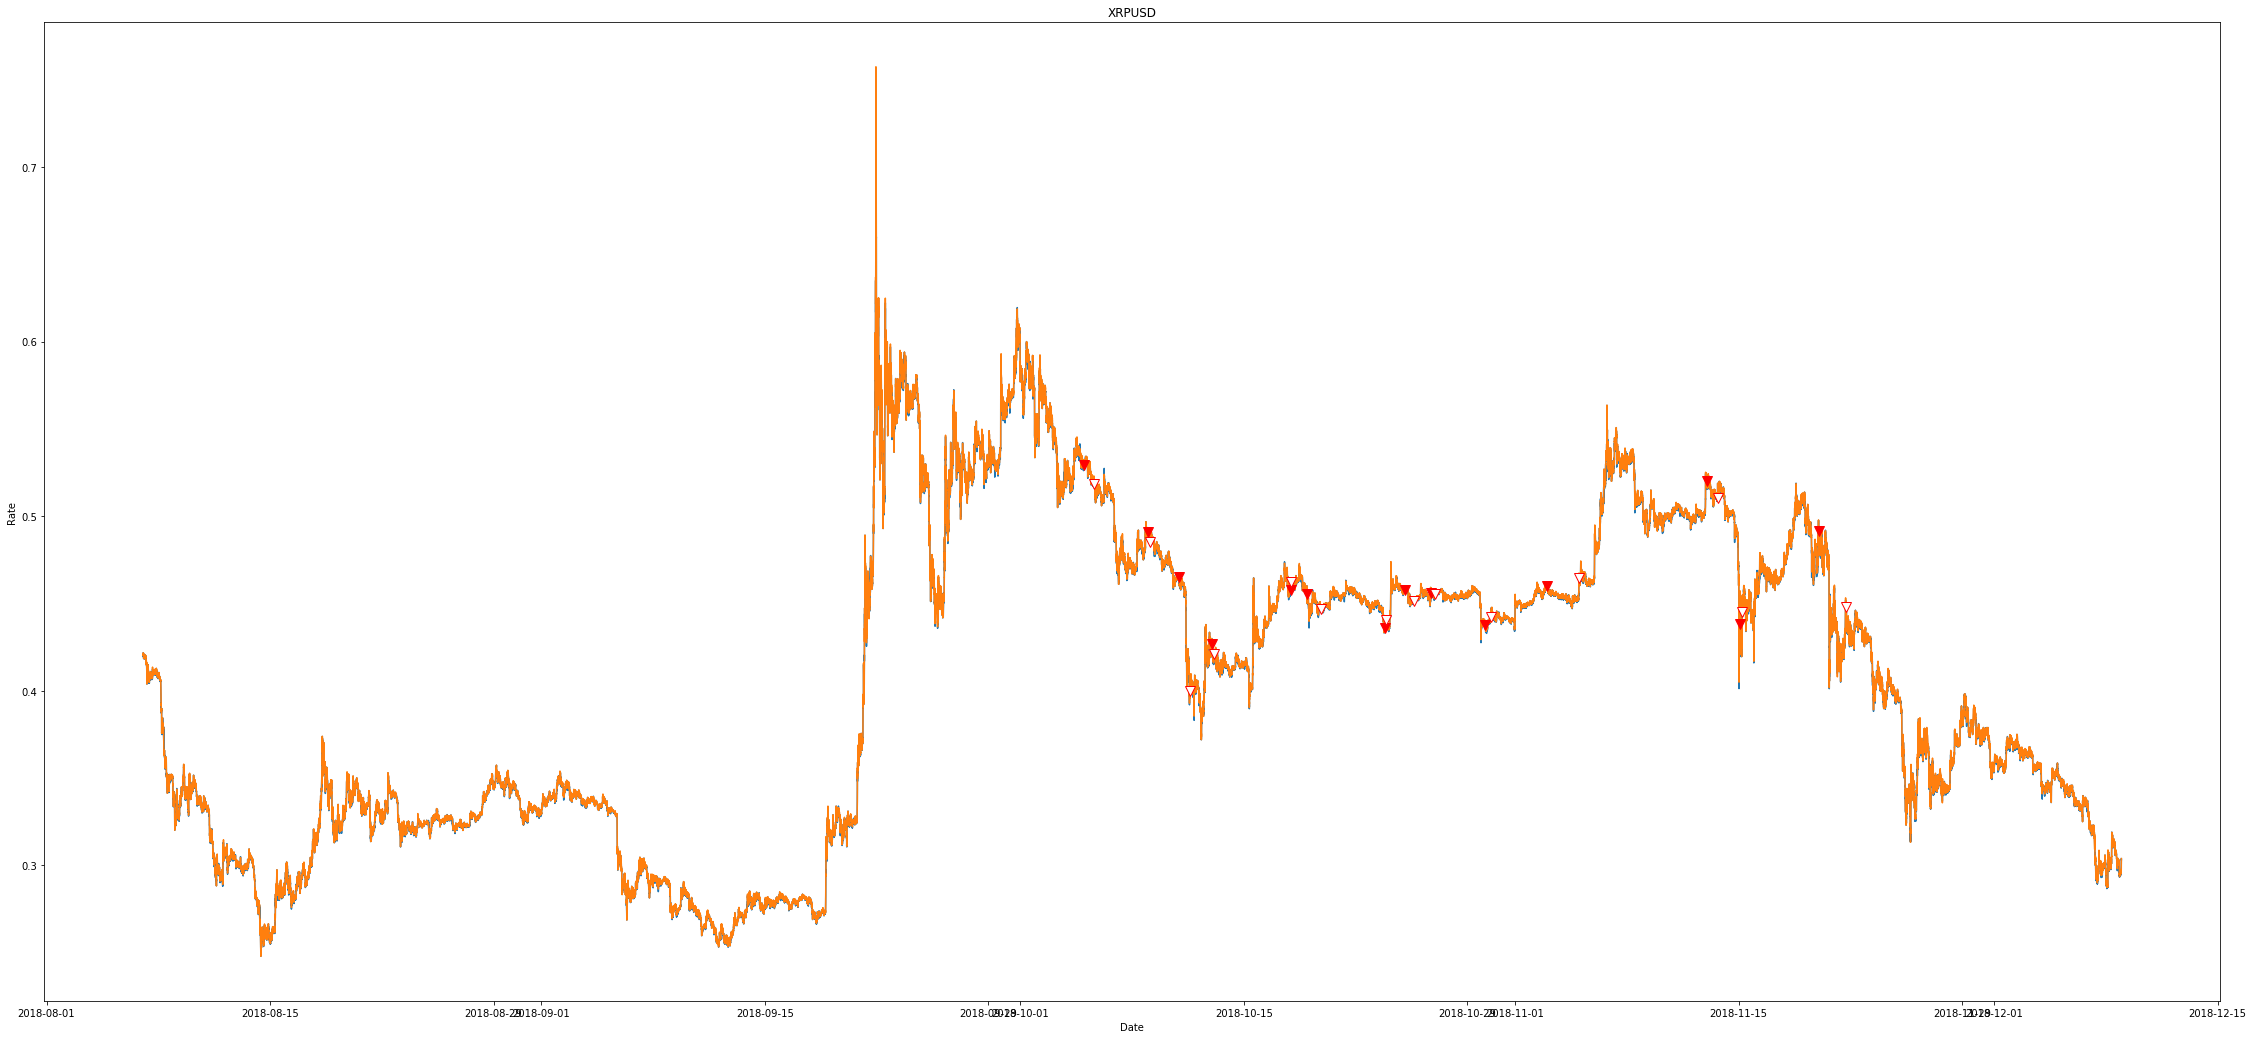

Activities:
    Product Position  Open Rate Close Rate      P&L
0    HKDTRY    SHORT        0.8        0.8 317418.9
1       HSI     LONG    27750.0    27690.0  -9200.0
2       PUT    SHORT      503.7      527.1  -1366.3
3       HSI    SHORT    27667.0    27944.0 -41750.0
4      CALL    SHORT      520.9      436.8   4005.6
5       HSI    SHORT    27628.0    27113.0  77050.0
6      CALL    SHORT      521.0      759.5 -12126.4
7       HSI    SHORT    27134.0    26968.0  24700.0
8       PUT     LONG      449.0      514.5   3075.8
9       HSI    SHORT    27106.0    26852.0  37900.0
10      PUT     LONG      444.0      547.9   4999.2
11      HSI    SHORT    26605.0    26620.0  -2450.0
12      PUT     LONG      424.7      418.8   -493.7
13      HSI    SHORT    26548.0    26347.0  29950.0
14      PUT     LONG      350.3      426.3   3602.4
15      HSI    SHORT    26230.0    26363.0 -20150.0
16      PUT     LONG      372.2      324.3  -2595.3
17      HSI     LONG    26890.0    27026.0  20200.0


In [8]:
from pylab import *
rcParams['figure.figsize'] = (39, 18)
# %% Export Portfolio
tradelog = None
portfolio, tradelog = platform.exporttrades()
for i in range(len(tradelog)):
    tradelog.loc[i, 'P&L'] = tradelog.loc[i, 'Unrealized P&L'] + tradelog.loc[i, 'Realized P&L']
print('Activities:')
print(tradelog[['Product', 'Position', 'Open Rate', 'Close Rate', 'P&L']])
print('Summary:')
print('Initial Cash:', round(portfolio['initial']), 'Final Cash:', round(portfolio['cash']))
print('Unrealized P&L:', round(portfolio['Unrealized P&L']), 'Realized P&L:', round(portfolio['Realized P&L']))
print('Overall P&L:', round(portfolio['P&L']), 'P&L%:', round(portfolio['P&L%']))


In [7]:
# %% insert
tradelog.to_excel('df1.xlsx')